
# Assignment: Linear Regression, Logistic Regression, and K-Means (From Scratch)

**Instructions**
- You are NOT allowed to use `scikit-learn` for model implementation, scaling.
- You may use it for implementation of clustering
- You may use: `numpy`, `matplotlib`, and standard Python libraries only.
- Every step (scaling, loss, gradients, optimization) must be implemented manually.
- Clearly comment your code and explain your reasoning in Markdown cells.


## Question 1: Linear Regression from Scratch (with Standardization and Regularization)

You are given a dataset `(X, y)`.

### Tasks
1. Implement **StandardScaler manually**:
   - Compute mean and standard deviation for each feature.
   - Standardize the features.
2. Implement **Linear Regression using Gradient Descent**.
3. Add **L2 Regularization (Ridge Regression)**.
4. Plot:
   - Loss vs iterations
   - True vs predicted values

Do NOT use `sklearn`.


In [10]:
import numpy as np
import matplotlib.pyplot as plt


In [11]:
# Implement StandardScaler manually
class StandardScalerManual:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None
        self.fitted_ = False

    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array")
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0, ddof=0)
        self.scale_ = np.where(self.scale_ < 1e-12, 1.0, self.scale_)
        self.fitted_ = True
        return self

    def transform(self, X):
        if not self.fitted_:
            raise RuntimeError("StandardScalerManual is not fitted yet")
        X = np.asarray(X, dtype=np.float64)
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        return self.fit(X).transform(X)

# This is a small sanity check
X_demo = np.array([[1.0, 2.0], [3.0, 0.0], [5.0, 4.0]])
sc_demo = StandardScalerManual()
Xz_demo = sc_demo.fit_transform(X_demo)
print("Scaler demo mean:", sc_demo.mean_)
print("Scaler demo std:", sc_demo.scale_)
print("Scaler demo transformed mean (approx):", Xz_demo.mean(axis=0))
print("Scaler demo transformed std (approx):", Xz_demo.std(axis=0))


Scaler demo mean: [3. 2.]
Scaler demo std: [1.63299316 1.63299316]
Scaler demo transformed mean (approx): [0. 0.]
Scaler demo transformed std (approx): [1. 1.]


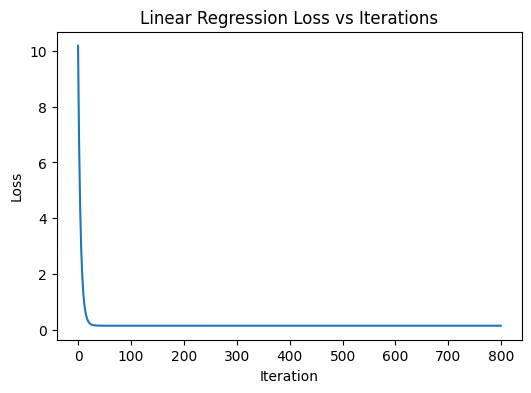

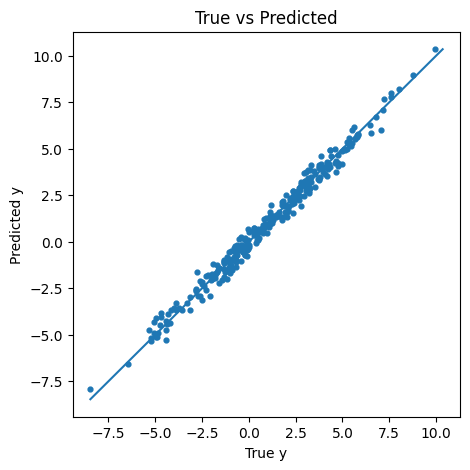

Final training MSE: 0.14446240160896348
Learned weights (bias first): [ 0.95673771  2.4846817  -1.63999903]


In [12]:
# Implement Linear Regression from scratch with L2 regularization
class LinearRegressionManual:
    def __init__(self, lr=0.01, epochs=1000, l2_lambda=0.0):
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.l2_lambda = float(l2_lambda)
        self.w = None
        self.loss_history = []

    def _add_bias(self, X):
        X = np.asarray(X, dtype=np.float64)
        ones = np.ones((X.shape[0], 1), dtype=np.float64)
        return np.concatenate([ones, X], axis=1)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64).reshape(-1)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array")
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples")

        Xb = self._add_bias(X)
        n, d = Xb.shape
        self.w = np.zeros(d, dtype=np.float64)
        self.loss_history = []

        for _ in range(self.epochs):
            yhat = Xb @ self.w
            err = yhat - y

            mse = (err @ err) / n
            reg = self.l2_lambda * (self.w[1:] @ self.w[1:])
            loss = mse + reg
            self.loss_history.append(float(loss))

            grad = (2.0 / n) * (Xb.T @ err)
            grad[1:] = grad[1:] + 2.0 * self.l2_lambda * self.w[1:]
            self.w = self.w - self.lr * grad

        return self

    def predict(self, X):
        if self.w is None:
            raise RuntimeError("Model not fitted yet")
        Xb = self._add_bias(X)
        return Xb @ self.w

# Using synthetic data to check implementation of the algorithm
np.random.seed(7)
n = 300
X = np.random.randn(n, 2)
true_w = np.array([2.5, -1.7])
y = X @ true_w + 0.8 + 0.4 * np.random.randn(n)

scaler = StandardScalerManual()
Xz = scaler.fit_transform(X)

model = LinearRegressionManual(lr=0.05, epochs=800, l2_lambda=1e-3)
model.fit(Xz, y)
y_pred = model.predict(Xz)

plt.figure(figsize=(6, 4))
plt.plot(model.loss_history)
plt.title("Linear Regression Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(y, y_pred, s=12)
mn = min(y.min(), y_pred.min())
mx = max(y.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx])
plt.title("True vs Predicted")
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.show()

print("Final training MSE:", float(np.mean((y_pred - y) ** 2)))
print("Learned weights (bias first):", model.w)


### Real-world Diabetes dataset experiment (Linear Regression)

I am validating my linear regression implementation on a **real Diabetes dataset** from `sklearn.datasets`.
I have added richer plots: feature correlations, loss curve, true-vs-pred scatter, and residual diagnostics.


Diabetes dataset shapes: (442, 10) (442,)
Train MSE: 2799.2061596961444 Test MSE: 3258.846215700481
Train R2 : 0.5464877584329293 Test R2 : 0.3440328319884093


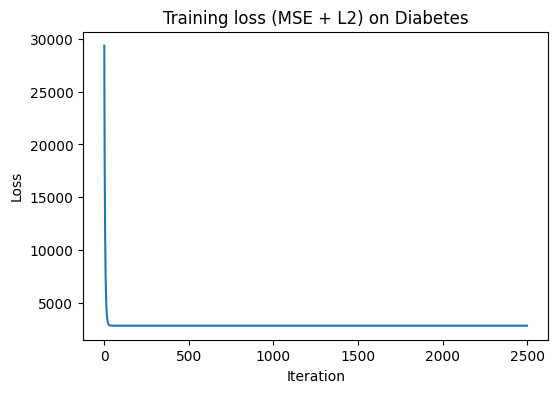

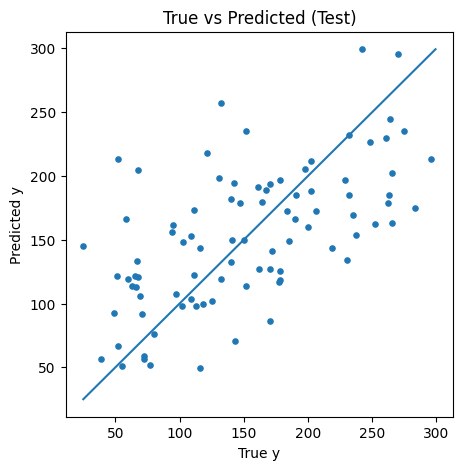

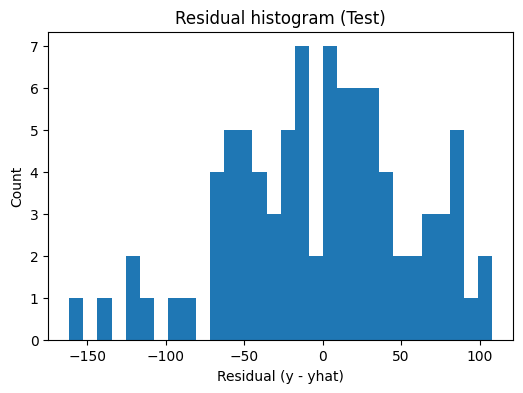

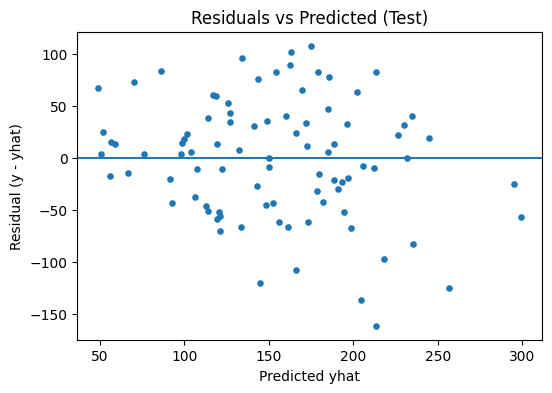

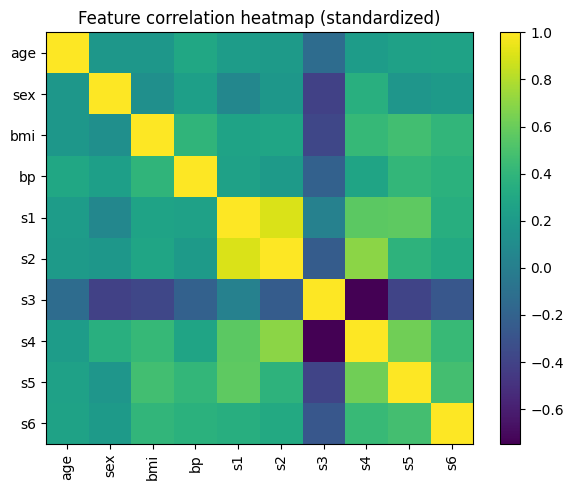

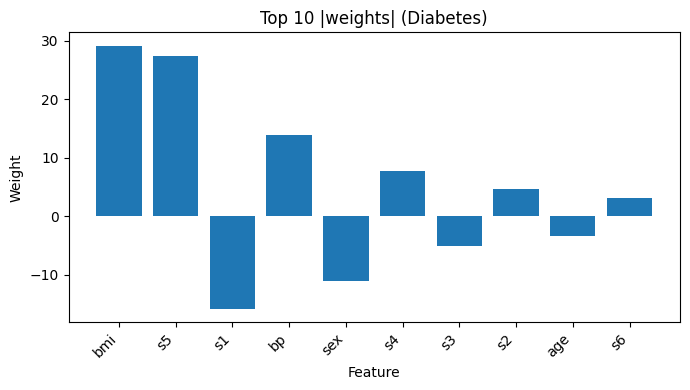

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes

data = load_diabetes()
X_real = data.data.astype(np.float64)
y_real = data.target.astype(np.float64)
feature_names = list(data.feature_names)

rng = np.random.default_rng(0)
idx = rng.permutation(X_real.shape[0])
split = int(0.8 * len(idx))
tr, te = idx[:split], idx[split:]

Xtr, Xte = X_real[tr], X_real[te]
ytr, yte = y_real[tr], y_real[te]

sc = StandardScalerManual()
Xtr_z = sc.fit_transform(Xtr)
Xte_z = sc.transform(Xte)

model_real = LinearRegressionManual(lr=0.05, epochs=2500, l2_lambda=0.0)
model_real.fit(Xtr_z, ytr)

pred_tr = model_real.predict(Xtr_z)
pred_te = model_real.predict(Xte_z)

mse_tr = float(np.mean((pred_tr - ytr) ** 2))
mse_te = float(np.mean((pred_te - yte) ** 2))

def r2_score(y, yhat):
    y = np.asarray(y, dtype=np.float64).reshape(-1)
    yhat = np.asarray(yhat, dtype=np.float64).reshape(-1)
    ss_res = float(np.sum((y - yhat) ** 2))
    ss_tot = float(np.sum((y - y.mean()) ** 2))
    return 1.0 - ss_res / (ss_tot + 1e-12)

r2_tr = float(r2_score(ytr, pred_tr))
r2_te = float(r2_score(yte, pred_te))

print("Diabetes dataset shapes:", X_real.shape, y_real.shape)
print("Train MSE:", mse_tr, "Test MSE:", mse_te)
print("Train R2 :", r2_tr, "Test R2 :", r2_te)

plt.figure(figsize=(6, 4))
plt.plot(model_real.loss_history)
plt.title("Training loss (MSE + L2) on Diabetes")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(yte, pred_te, s=14)
mn = float(min(yte.min(), pred_te.min()))
mx = float(max(yte.max(), pred_te.max()))
plt.plot([mn, mx], [mn, mx])
plt.title("True vs Predicted (Test)")
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.show()

res = (yte - pred_te)
plt.figure(figsize=(6, 4))
plt.hist(res, bins=30)
plt.title("Residual histogram (Test)")
plt.xlabel("Residual (y - yhat)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(pred_te, res, s=14)
plt.axhline(0.0)
plt.title("Residuals vs Predicted (Test)")
plt.xlabel("Predicted yhat")
plt.ylabel("Residual (y - yhat)")
plt.show()

C = np.corrcoef(Xtr_z, rowvar=False)
plt.figure(figsize=(6, 5))
plt.imshow(C, aspect="auto")
plt.title("Feature correlation heatmap (standardized)")
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar()
plt.tight_layout()
plt.show()

w = model_real.w.copy()
w_nobias = w[1:]
order = np.argsort(np.abs(w_nobias))[::-1][:10]
plt.figure(figsize=(7, 4))
plt.bar([feature_names[i] for i in order], w_nobias[order])
plt.title("Top 10 |weights| (Diabetes)")
plt.xlabel("Feature")
plt.ylabel("Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


**Observations (example):**
- Loss should decrease and then stabilize; if it oscillates, reduce the learning rate.
- The **true vs predicted** plot should roughly align with the diagonal; large spread indicates underfitting.
- Residuals ideally look centered around 0; strong patterns suggest missing nonlinearities or interactions.



## Question 2: Logistic Regression from Scratch (with Standardization and Regularization)

You are given a binary classification dataset.

### Tasks
1. Reuse your **manual StandardScaler**.
2. Implement **Logistic Regression using Gradient Descent**.
3. Use:
   - Sigmoid function
   - Binary Cross Entropy loss
4. Add **L2 Regularization**.
5. Report:
   - Training loss curve
   - Final accuracy

Do NOT use `sklearn`.


In [14]:
# Implement sigmoid function
def sigmoid(z):
    z = np.asarray(z, dtype=np.float64)
    z = np.clip(z, -50.0, 50.0)
    return 1.0 / (1.0 + np.exp(-z))

# This is a quick sigmoid sanity check
print("sigmoid([-2,0,2]) =", sigmoid(np.array([-2.0, 0.0, 2.0])))


sigmoid([-2,0,2]) = [0.11920292 0.5        0.88079708]


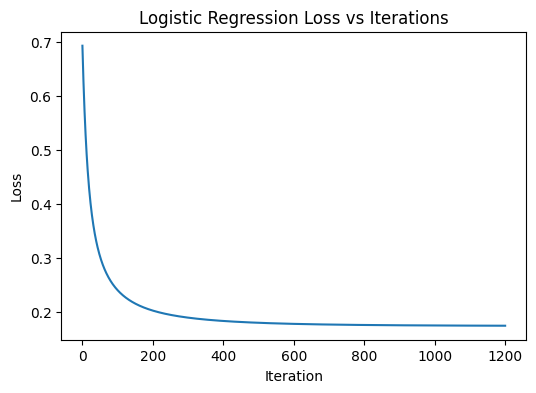

Final training accuracy: 0.936


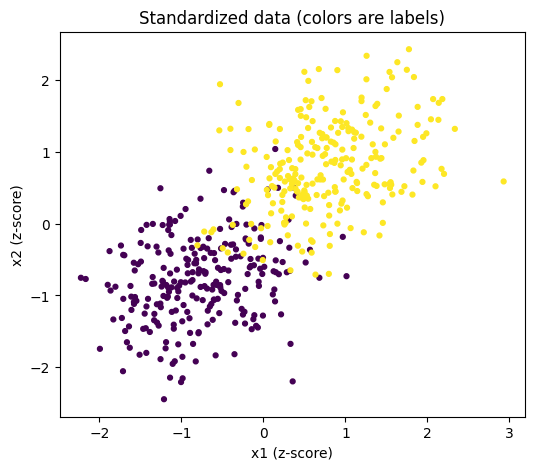

In [15]:
# Implement Logistic Regression from scratch with L2 regularization
class LogisticRegressionManual:
    def __init__(self, lr=0.01, epochs=1000, l2_lambda=0.0):
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.l2_lambda = float(l2_lambda)
        self.w = None
        self.loss_history = []

    def _add_bias(self, X):
        X = np.asarray(X, dtype=np.float64)
        ones = np.ones((X.shape[0], 1), dtype=np.float64)
        return np.concatenate([ones, X], axis=1)

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64).reshape(-1)
        if X.ndim != 2:
            raise ValueError("X must be a 2D array")
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have the same number of samples")
        if not np.all((y == 0) | (y == 1)):
            raise ValueError("y must be binary (0/1)")

        Xb = self._add_bias(X)
        n, d = Xb.shape
        self.w = np.zeros(d, dtype=np.float64)
        self.loss_history = []

        for _ in range(self.epochs):
            logits = Xb @ self.w
            p = sigmoid(logits)

            p = np.clip(p, 1e-12, 1.0 - 1e-12)
            bce = -np.mean(y * np.log(p) + (1.0 - y) * np.log(1.0 - p))
            reg = self.l2_lambda * (self.w[1:] @ self.w[1:])
            loss = bce + reg
            self.loss_history.append(float(loss))

            grad = (1.0 / n) * (Xb.T @ (p - y))
            grad[1:] = grad[1:] + 2.0 * self.l2_lambda * self.w[1:]
            self.w = self.w - self.lr * grad

        return self

    def predict_proba(self, X):
        if self.w is None:
            raise RuntimeError("Model not fitted yet")
        Xb = self._add_bias(X)
        return sigmoid(Xb @ self.w)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(np.int64)

# Using a synthetic diabetes dataset.
np.random.seed(11)
n0, n1 = 250, 250
mu0 = np.array([-1.2, -0.8])
mu1 = np.array([ 1.0,  1.3])
cov = np.array([[0.8, 0.2],[0.2, 0.7]])

X0 = np.random.multivariate_normal(mu0, cov, size=n0)
X1 = np.random.multivariate_normal(mu1, cov, size=n1)
X_cls = np.vstack([X0, X1])
y_cls = np.hstack([np.zeros(n0, dtype=np.int64), np.ones(n1, dtype=np.int64)])

scaler2 = StandardScalerManual()
Xz_cls = scaler2.fit_transform(X_cls)

clf = LogisticRegressionManual(lr=0.08, epochs=1200, l2_lambda=1e-3)
clf.fit(Xz_cls, y_cls)

plt.figure(figsize=(6, 4))
plt.plot(clf.loss_history)
plt.title("Logistic Regression Loss vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

pred = clf.predict(Xz_cls)
acc = float((pred == y_cls).mean())
print("Final training accuracy:", acc)

plt.figure(figsize=(6, 5))
plt.scatter(Xz_cls[:, 0], Xz_cls[:, 1], c=y_cls, s=12)
plt.title("Standardized data (colors are labels)")
plt.xlabel("x1 (z-score)")
plt.ylabel("x2 (z-score)")
plt.show()


### Real-world Breast Cancer dataset experiment (Logistic Regression)

I am evaluating my logistic regression implementation on the **Breast Cancer Wisconsin** dataset (binary classification).
I am adding: loss curve, confusion matrix, ROC curve, probability histogram, and a 2D PCA visualization.


Breast cancer dataset shapes: (569, 30) (569,)
Test Accuracy: 0.9824561403508771
Precision: 0.986842105263145 Recall: 0.986842105263145 F1: 0.9868421052626449


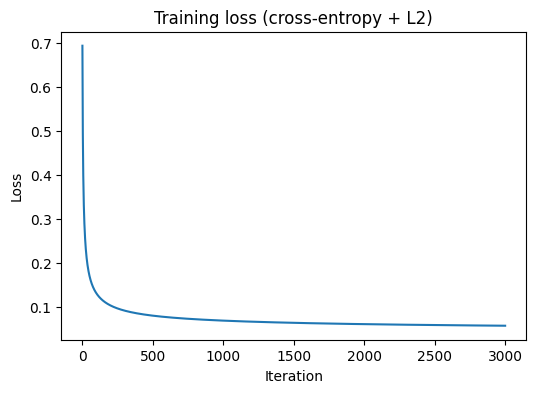

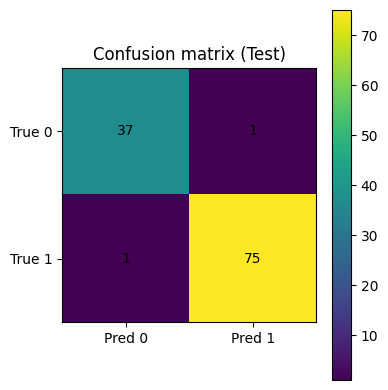

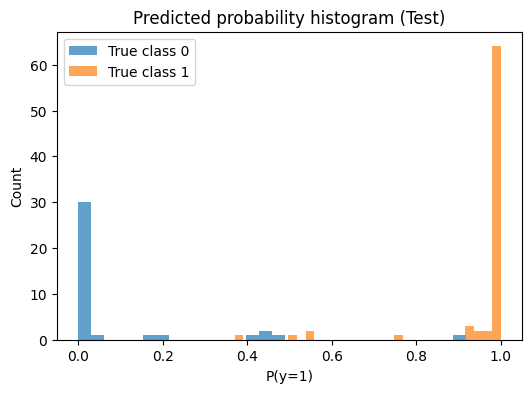

/tmp/ipython-input-3743861755.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = float(np.trapz(tpr, fpr))


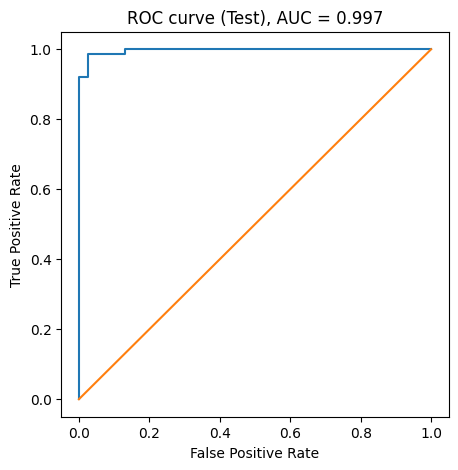

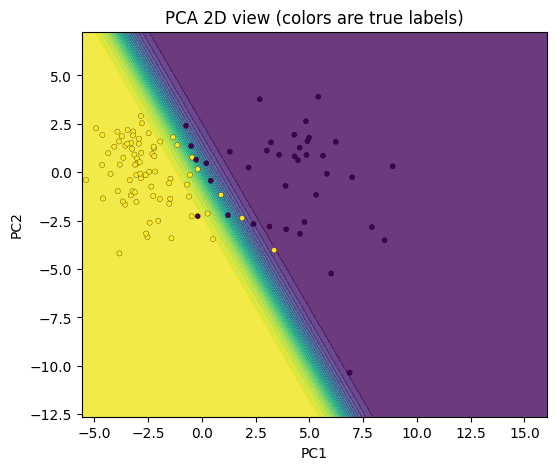

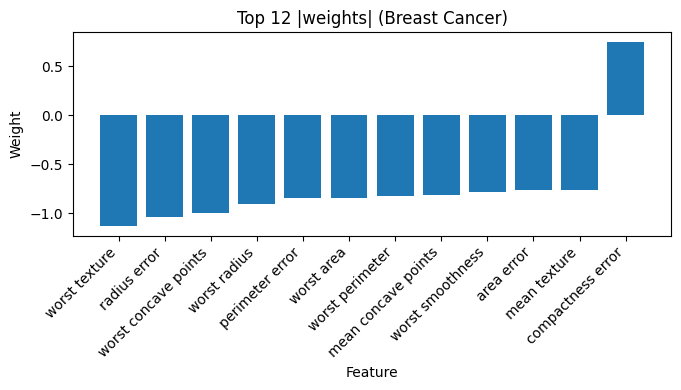

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X_real = data.data.astype(np.float64)
y_real = data.target.astype(np.int64)
feature_names = list(data.feature_names)

rng = np.random.default_rng(1)
idx = rng.permutation(X_real.shape[0])
split = int(0.8 * len(idx))
tr, te = idx[:split], idx[split:]

Xtr, Xte = X_real[tr], X_real[te]
ytr, yte = y_real[tr], y_real[te]

sc = StandardScalerManual()
Xtr_z = sc.fit_transform(Xtr)
Xte_z = sc.transform(Xte)

clf_real = LogisticRegressionManual(lr=0.05, epochs=3000, l2_lambda=0.0)
clf_real.fit(Xtr_z, ytr)

proba_te = clf_real.predict_proba(Xte_z)
pred_te = (proba_te >= 0.5).astype(np.int64)

acc = float((pred_te == yte).mean())
tp = int(np.sum((pred_te == 1) & (yte == 1)))
tn = int(np.sum((pred_te == 0) & (yte == 0)))
fp = int(np.sum((pred_te == 1) & (yte == 0)))
fn = int(np.sum((pred_te == 0) & (yte == 1)))

prec = float(tp / (tp + fp + 1e-12))
rec = float(tp / (tp + fn + 1e-12))
f1 = float(2 * prec * rec / (prec + rec + 1e-12))

print("Breast cancer dataset shapes:", X_real.shape, y_real.shape)
print("Test Accuracy:", acc)
print("Precision:", prec, "Recall:", rec, "F1:", f1)

plt.figure(figsize=(6, 4))
plt.plot(clf_real.loss_history)
plt.title("Training loss (cross-entropy + L2)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

cm = np.array([[tn, fp],
               [fn, tp]], dtype=np.int64)

plt.figure(figsize=(4, 4))
plt.imshow(cm, aspect="equal")
plt.title("Confusion matrix (Test)")
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(proba_te[yte == 0], bins=30, alpha=0.7, label="True class 0")
plt.hist(proba_te[yte == 1], bins=30, alpha=0.7, label="True class 1")
plt.title("Predicted probability histogram (Test)")
plt.xlabel("P(y=1)")
plt.ylabel("Count")
plt.legend()
plt.show()

def roc_curve_manual(y_true, scores):
    y_true = np.asarray(y_true).astype(np.int64).reshape(-1)
    scores = np.asarray(scores).astype(np.float64).reshape(-1)
    order = np.argsort(scores)[::-1]
    y = y_true[order]
    s = scores[order]
    P = float(np.sum(y == 1))
    N = float(np.sum(y == 0))
    tpr = [0.0]
    fpr = [0.0]
    tp = 0.0
    fp = 0.0
    last = None
    for yi, si in zip(y, s):
        if last is None or si != last:
            tpr.append(tp / (P + 1e-12))
            fpr.append(fp / (N + 1e-12))
            last = si
        if yi == 1:
            tp += 1.0
        else:
            fp += 1.0
    tpr.append(tp / (P + 1e-12))
    fpr.append(fp / (N + 1e-12))
    return np.array(fpr), np.array(tpr)

fpr, tpr = roc_curve_manual(yte, proba_te)

auc = float(np.trapz(tpr, fpr))
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.title("ROC curve (Test), AUC = %.3f" % auc)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

X2 = Xtr_z - Xtr_z.mean(axis=0, keepdims=True)
U, S, Vt = np.linalg.svd(X2, full_matrices=False)
W2 = Vt[:2].T
Ztr = Xtr_z @ W2
Zte = Xte_z @ W2

clf_2d = LogisticRegressionManual(lr=0.1, epochs=2000, l2_lambda=0.0)
clf_2d.fit(Ztr, ytr)

xx, yy = np.meshgrid(np.linspace(Ztr[:, 0].min(), Ztr[:, 0].max(), 200),
                     np.linspace(Ztr[:, 1].min(), Ztr[:, 1].max(), 200))
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
pp = clf_2d.predict_proba(grid).reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, pp, levels=20, alpha=0.8)
plt.scatter(Zte[:, 0], Zte[:, 1], c=yte, s=14, edgecolors="k", linewidths=0.2)
plt.title("PCA 2D view (colors are true labels)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

w = clf_real.w.copy()
w_nobias = w[1:]
order = np.argsort(np.abs(w_nobias))[::-1][:12]
plt.figure(figsize=(7, 4))
plt.bar([feature_names[i] for i in order], w_nobias[order])
plt.title("Top 12 |weights| (Breast Cancer)")
plt.xlabel("Feature")
plt.ylabel("Weight")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


**Observations (example):**
- The ROC curve should bow toward the top-left if the classifier separates classes well.
- A confusion matrix dominated by the diagonal indicates good performance; many FP or FN suggests threshold tuning.
- PCA visualization is only for intuition; the real model still uses all features.



## Question 3: K-Means Clustering from Scratch (Matrix Clustering)

You are given a **random matrix** `M` of shape `(n, m)`.

### Tasks
Implement K-Means clustering **from scratch** such that:

1. Input:
   - A random matrix `M`
   - Number of clusters `k`
2. Output:
   - `assignment_table`: a matrix of same shape as `M`, where each element stores the **cluster label**
   - `cookbook`: a dictionary (hashmap) where:
     - Key = cluster index
     - Value = list of **positions (i, j)** belonging to that cluster
   - `centroids`: array storing centroid values

You must cluster **individual elements**, not rows.


Centroids: [-1.89083774  2.07560557  4.2474571   0.21040777]
Cluster sizes: {0: 435, 1: 810, 2: 310, 3: 845}


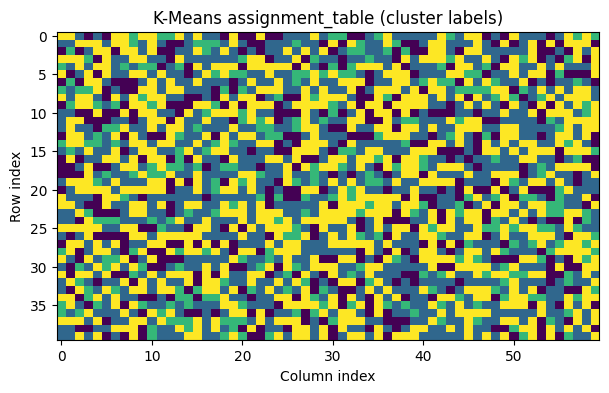

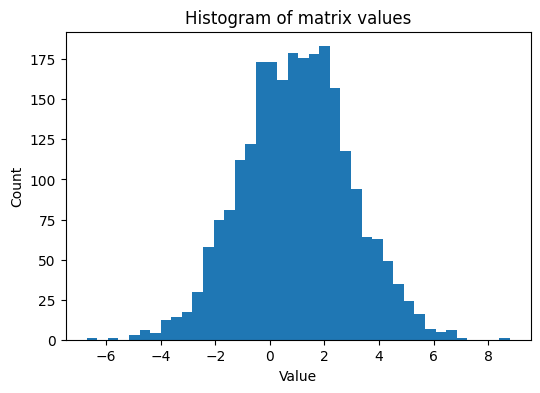

In [17]:
# Implement K-Means for matrix elements
def kmeans_matrix(M, k, max_iters=100):
    M = np.asarray(M, dtype=np.float64)
    if M.ndim != 2:
        raise ValueError("M must be a 2D matrix")
    if k <= 0:
        raise ValueError("k must be positive")

    vals = M.reshape(-1)
    n = vals.shape[0]
    rng = np.random.default_rng(42)

    if k > n:
        raise ValueError("k cannot be larger than number of elements")

    init_idx = rng.choice(n, size=k, replace=False)
    centroids = vals[init_idx].copy()

    labels = np.zeros(n, dtype=np.int64)

    for _ in range(int(max_iters)):
        dist = np.abs(vals[:, None] - centroids[None, :])
        new_labels = np.argmin(dist, axis=1)

        if np.array_equal(new_labels, labels):
            labels = new_labels
            break
        labels = new_labels

        for c in range(k):
            mask = labels == c
            if np.any(mask):
                centroids[c] = vals[mask].mean()
            else:
                centroids[c] = vals[rng.integers(0, n)]

    assignment_table = labels.reshape(M.shape)

    cookbook = {cid: [] for cid in range(k)}
    for idx, cid in enumerate(labels):
        i = idx // M.shape[1]
        j = idx % M.shape[1]
        cookbook[int(cid)].append((int(i), int(j)))

    return assignment_table, cookbook, centroids

# Using random matrix (synthetic data)
np.random.seed(21)
M = np.random.randn(40, 60) * 2.0 + 1.0
k = 4
assignment_table, cookbook, centroids = kmeans_matrix(M, k=k, max_iters=80)

print("Centroids:", centroids)
print("Cluster sizes:", {c: len(cookbook[c]) for c in cookbook})

plt.figure(figsize=(7, 4))
plt.imshow(assignment_table, aspect="auto")
plt.title("K-Means assignment_table (cluster labels)")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(M.reshape(-1), bins=40)
plt.title("Histogram of matrix values")
plt.xlabel("Value")
plt.ylabel("Count")
plt.show()


### Real-world dataset experiment (K-Means)

I am testing my K-Means (matrix-element clustering) implementation on a **real image** packaged with scikit-learn (`load_sample_image`).
I have clustered the grayscale intensities and visualizing **image quantization** for different `k`, plus an elbow plot.


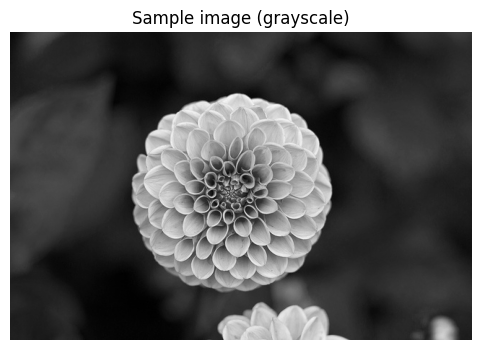

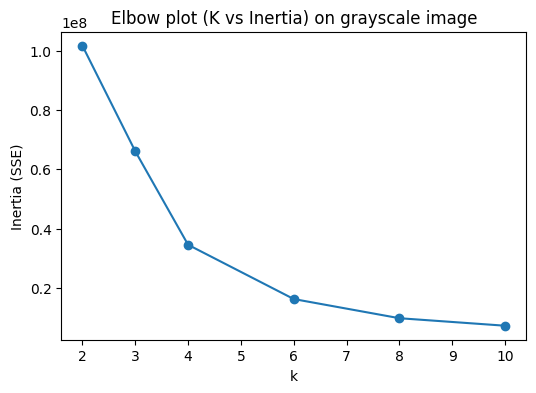

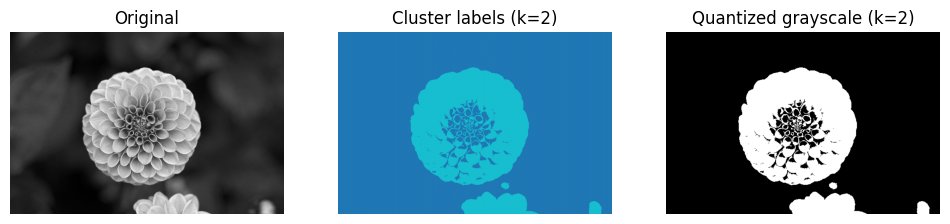

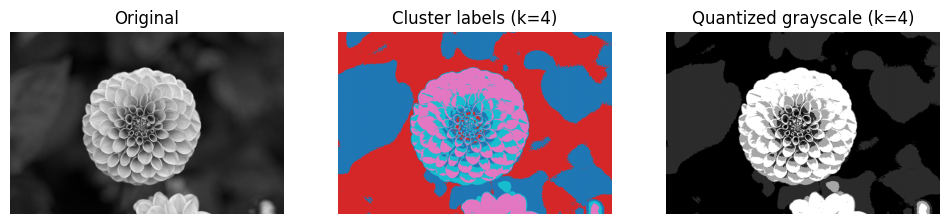

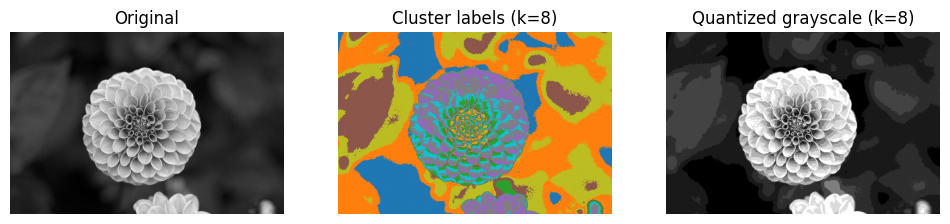

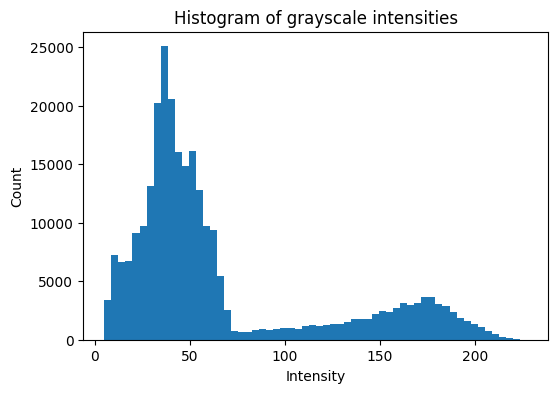

In [18]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_sample_image

img = load_sample_image("flower.jpg")
img = img.astype(np.float64)

gray = (0.299 * img[..., 0] + 0.587 * img[..., 1] + 0.114 * img[..., 2]).astype(np.float64)

plt.figure(figsize=(6, 4))
plt.imshow(gray, cmap="gray")
plt.title("Sample image (grayscale)")
plt.axis("off")
plt.show()

def kmeans_inertia_1d(vals, labels, centroids):
    vals = np.asarray(vals, dtype=np.float64).reshape(-1)
    labels = np.asarray(labels, dtype=np.int64).reshape(-1)
    centroids = np.asarray(centroids, dtype=np.float64).reshape(-1)
    return float(np.sum((vals - centroids[labels]) ** 2))

ks = [2, 3, 4, 6, 8, 10]
inertias = []

for k in ks:
    assign, cookbook, centroids = kmeans_matrix(gray, k=k, max_iters=30)
    inertia = kmeans_inertia_1d(gray, assign, centroids)
    inertias.append(inertia)

plt.figure(figsize=(6, 4))
plt.plot(ks, inertias, marker="o")
plt.title("Elbow plot (K vs Inertia) on grayscale image")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.show()

for k in [2, 4, 8]:
    assign, cookbook, centroids = kmeans_matrix(gray, k=k, max_iters=40)
    centroids = np.asarray(centroids, dtype=np.float64)
    q = centroids[np.asarray(assign, dtype=np.int64)]
    q = np.clip(q, 0, 255)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(assign, cmap="tab10", vmin=0, vmax=k-1)
    plt.title("Cluster labels (k=%d)" % k)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(q, cmap="gray")
    plt.title("Quantized grayscale (k=%d)" % k)
    plt.axis("off")
    plt.show()

plt.figure(figsize=(6, 4))
plt.hist(gray.reshape(-1), bins=60)
plt.title("Histogram of grayscale intensities")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.show()


**Observations (example):**
- As `k` increases, the quantized image retains more detail but may over-segment subtle shading.
- The elbow plot helps choose a reasonable `k` where inertia stops decreasing sharply.
- Cluster label maps often reveal lighting gradients and texture structure.



## Submission Guidelines
- Submit the completed `.ipynb` file.
- Clearly label all plots and outputs.
- Code readability and correctness matter.
- Partial credit will be given for logically correct implementations.

**Bonus**
- Compare convergence with and without standardization.
- Try different values of regularization strength.
